In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import dill
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import os
from pathlib import Path
import consts as C
import ipywidgets as widgets

from os import listdir
from os.path import isfile, join
import brian2 as b2
import datetime
from cochleas.anf_utils import load_anf_response
from cochleas.anf_response import AnfResponse
import brian2hears as b2h

2024-08-21 14:07:41,741 [INFO ]  

>>>>> start execution


In [2]:
results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (8, 3)
print(results_dir)

/home/paolo/Documents/school/master/polimi/thesis/polithesis/src/../results


In [3]:
# def draw_tone_vs_ANF(data, angle):
#     input = data["basesound"]
#     cochlea_key = data["conf"]["cochlea_type"]
#     anf: AnfResponse = load_anf_response(input, angle, cochlea_key)

#     ihf_most_spikes = (None, 0)
#     for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items():
#         if len(spike_times) > ihf_most_spikes[1]:
#             ihf_most_spikes = (ihf_idx, len(spike_times))
#     ihf_spikes = [
#         len(spike_times)
#         for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items()
#     ]
#     print(
#         f"the IHF 'spiking' at highest frequency is n.{ihf_most_spikes[0]}, spikes {ihf_most_spikes[1]}/s"
#     )
#     # plt.plot(ihf_spikes)
#     # plt.show()

#     print(anf.binaural_anf_spiketrain["L"][1241])
#     # plt.scatter(
#     #     anf.binaural_anf_spiketrain["L"][1241] / b2.second,
#     #     [1] * len(anf.binaural_anf_spiketrain["L"][1241]),
#     # )


# result_file = "tone_1.kHz_70dB&realistic_subj1002&inh_model&default_params&2024-08-02T19:37:28.pic"
# # result_file = "tone_1.kHz_70dB&ppg&inh_model&default_params&2024-08-02T19:56:40.pic"
# angle = 90
# with open(join(results_dir, result_file), "rb") as f:
#     res = dill.load(f, ignore=True)
#     draw_tone_vs_ANF(res, angle)

2024-08-12 18:57:17,846 [INFO ]  generating simulated IHC response...
2024-08-12 18:57:28,798 [INFO ]  generation complete.
the IHF 'spiking' at highest frequency is n.1130, spikes 555/s
plotting all IHF with corresponding total spike count


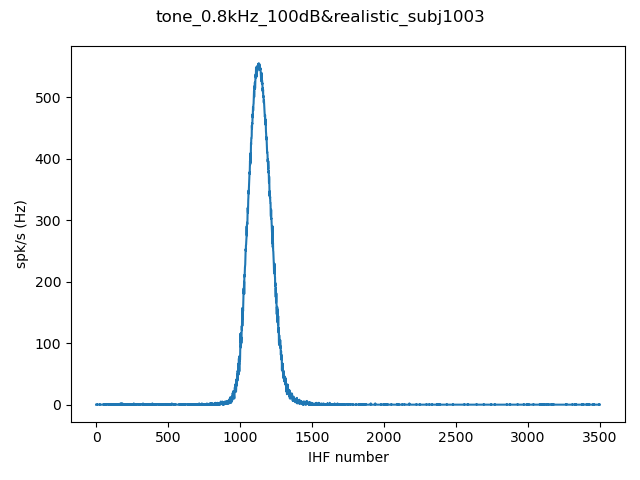

No such comm: efdf2617639549b49cdf67fa5256c211


In [4]:
from utils.custom_sounds import Tone
from cochleas.RealisticCochlea import sound_to_spikes
from cochleas.anf_utils import create_sound_key

freq = 0.8 * b2.kHz
tone = Tone(freq)
level = 100
angle = -90
cochlea_key = "realistic_subj1003"
tone.sound.level = level * b2h.dB
ex_key = f"{create_sound_key(tone)}&{cochlea_key}"

anf = sound_to_spikes(tone, angle, False)
ihf_most_spikes = (None, 0)
for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items():
    if len(spike_times) > ihf_most_spikes[1]:
        ihf_most_spikes = (ihf_idx, len(spike_times))
ihf_spikes = [
    len(spike_times)
    for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items()
]
print(
    f"the IHF 'spiking' at highest frequency is n.{ihf_most_spikes[0]}, spikes {ihf_most_spikes[1]}/s"
)
fig = plt.figure()
fig.suptitle(ex_key)
plt.plot(ihf_spikes)
plt.xlabel("IHF number")
plt.ylabel("spk/s (Hz)")
print("plotting all IHF with corresponding total spike count")
fig.tight_layout()
plt.show()

{'spikest_ihf_left': 1130, 'spikest_ihf_right': 1138, 'num_left': 555, 'num_right': 352}
[200.31746032 * msecond, 204.08163265 * msecond, 205.53287982 * msecond, 207.98185941 * msecond, 211.4739229 * msecond, 214.12698413 * msecond, 215.55555556 * msecond, 217.82312925 * msecond, 219.41043084 * msecond, 221.56462585 * msecond, 224.05895692 * msecond, 226.64399093 * msecond, 229.18367347 * msecond]


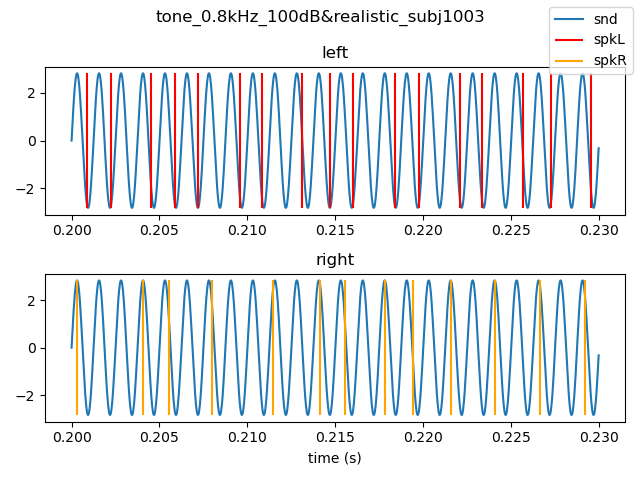

In [7]:
from sorcery import dict_of
from brian2 import ms, second
from math import inf

plt.close()

range = slice(200 * ms, 230 * ms)

anf_left, anf_right = (
    anf.binaural_anf_spiketrain["L"],
    anf.binaural_anf_spiketrain["R"],
)
spikest_ihf_left, _ = max(anf_left.items(), key=lambda x: len(set(x[1] / ms)))
spikest_ihf_right, _ = max(anf_right.items(), key=lambda x: len(set(x[1] / ms)))
print(
    dict_of(
        spikest_ihf_left,
        spikest_ihf_right,
        num_left=len(anf_left[spikest_ihf_left]),
        num_right=len(anf_right[spikest_ihf_right]),
    )
)

input = tone.sound
fig, [left, right] = plt.subplots(2, 1)
max_mag = max(np.array(input[range]))[0]


def select_in_range(full, spikest):
    return [i for i in full[spikest] if i >= range.start and i < range.stop]


spikest_anf_left_in_range = select_in_range(anf_left, spikest_ihf_right)
spikest_anf_right_in_range = select_in_range(anf_right, spikest_ihf_right)

print(spikest_anf_right_in_range)

fig.suptitle(ex_key)
left.plot(input[range].times + range.start, input[range], label="snd")
left.vlines(spikest_anf_left_in_range, -max_mag, max_mag, colors="r", label="spkL")
left.set_title("left")
right.plot(input[range].times + range.start, input[range])
right.vlines(
    spikest_anf_right_in_range, -max_mag, max_mag, colors="orange", label="spkR"
)
right.set_title("right")
right.set_xlabel("time (s)")
fig.legend()
fig.tight_layout()

In [31]:
max(np.array(input[range]))[0]

2.8284091824875097

In [5]:
from utils.custom_sounds import Tone
from cochleas.RealisticCochlea import sound_to_spikes
from cochleas.anf_utils import create_sound_key
import brian2hears as b2h
results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)


selected = "tone_80.Hz_110dB&realistic_subj1003&inh_model&1ms_rec_ANF&2024-08-12T20:08:40.pic"
selected = "tone_0.5kHz_100dB&realistic_subj1003&inh_model&1ms_rec_ANF&2024-08-13T20:05:00.pic"

with open(join(results_dir, selected), "rb") as f:
    data = dill.load(f, ignore=True)


freq = 80 * b2.Hz
tone = Tone(freq)
level = 110
angle = -90
cochlea_key = "realistic_subj1003"
tone.sound.level = level * b2h.dB
ex_key = f"{create_sound_key(tone)}&{cochlea_key}"

plt.close()
anf = load_anf_response(tone,angle,cochlea_key)

ihf_most_spikes = (None, 0)
for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items():
    if len(spike_times) > ihf_most_spikes[1]:
        ihf_most_spikes = (ihf_idx, len(spike_times))
ihf_spikes = [
    len(spike_times)
    for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items()
]
print(
    f"the IHF 'spiking' at highest frequency is n.{ihf_most_spikes[0]}, spikes {ihf_most_spikes[1]}/s"
)

the IHF 'spiking' at highest frequency is n.170, spikes 347/s


In [ ]:
anf.binaural_anf_spiketrain["L"]

In [4]:
from cochleas.anf_utils import spikes_to_nestgen
import nest

nest.ResetKernel()
nest.SetKernelStatus({"resolution": 0.01, "rng_seed": 1})

anfs_per_ear = spikes_to_nestgen(anf)
print(nest.biological_time * b2.ms)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:13:33

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Aug 13 19:00:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.
2024-08-13 19:00:16,790 [DEBUG]  current IHF index is 0.
 setting ANF from 0                         to 10 to value (given in ms) [ 24.73922902  26.91609977  28.7755102   37.9138322   40.81632653
  50.65759637  53.5600907   62.42630385  64.62585034  75.14739229
  76.98412698  88.18594104  91.4739229  101.24716553 103.85487528
 112.6984127  115.3968254  125.46485261 127.3015873  137.4829932
 139.3877551  141.29251701 150.79365079 162.99319728 165.23809524
 176.16780045 177.89115646 188.54875283 191.38321995 199.90929705
 202.04081633 204.44444444 212.15419

In [5]:

l_ANFs = anfs_per_ear["L"]
parrot_l_ANFs = nest.Create("parrot_neuron", len(l_ANFs))
rec = nest.Create("spike_recorder")
nest.Connect(l_ANFs, parrot_l_ANFs, "one_to_one")
nest.Connect(parrot_l_ANFs, rec, "all_to_all")
print(nest.biological_time * b2.ms)
nest.Simulate(1000)

0. s


In [6]:
anf_spikes = rec.get("events")["times"]*b2.ms
print(nest.biological_time * b2.ms)
print(l_ANFs[1].get())
print(rec.get("events")["times"])

1. s
{'allow_offgrid_times': True, 'element_type': 'stimulator', 'frozen': False, 'global_id': 2, 'label': '', 'local': True, 'model': 'spike_generator', 'model_id': 11, 'node_uses_wfr': False, 'origin': 0.0, 'precise_times': False, 'shift_now_spikes': False, 'spike_multiplicities': array([], dtype=int64), 'spike_times': array([ 24.74,  26.92,  28.78,  37.92,  40.82,  50.66,  53.56,  62.43,
        64.63,  75.15,  76.99,  88.19,  91.48, 101.25, 103.86, 112.7 ,
       115.4 , 125.47, 127.31, 137.49, 139.39, 141.3 , 150.8 , 163.  ,
       165.24, 176.17, 177.9 , 188.55, 191.39, 199.91, 202.05, 204.45,
       212.16, 214.61, 225.2 , 227.37, 238.46, 240.73, 251.16, 254.11,
       263.11, 266.63, 275.9 , 279.26, 288.12, 291.5 , 300.25, 312.93,
       314.93, 326.35, 339.48, 350.23, 353.93, 363.09, 366.49, 376.74,
       378.37, 387.85, 390.03, 401.16, 412.77, 414.74, 426.08, 429.55,
       437.67, 439.3 , 450.87, 453.63, 463.9 , 475.72, 478.26, 489.26,
       500.16, 503.25, 512.95, 514.83,

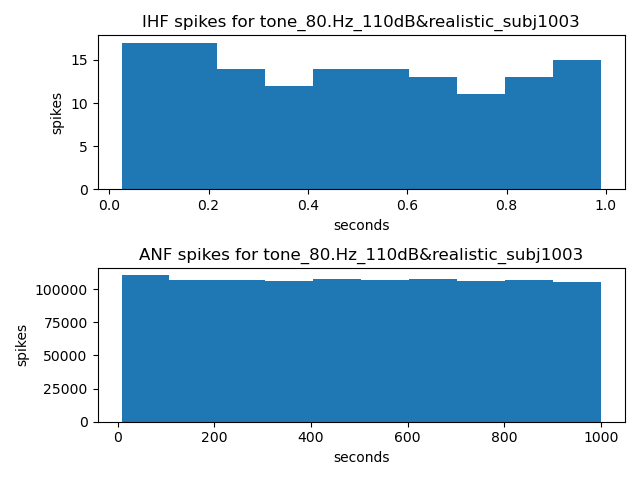

In [6]:
plt.close()
# max(anf.binaural_anf_spiketrain['L'][0])
fig, [ihf_plot, anf_plot] = plt.subplots(2, 1)
ihf_plot.hist(anf.binaural_anf_spiketrain["L"][0] / b2.second, label="spikes")
ihf_plot.set_title(f"IHF spikes for {ex_key}")
ihf_plot.set_ylabel("spikes")
ihf_plot.set_xlabel("seconds")

data["angle_to_rate"][-90]["L"]["ANF"]["spikes"]["times"] / 1000
# anf_plot.hist(anf_spikes/b2.second, label="spikes")
anf_plot.hist(data["angle_to_rate"][-90]["L"]["ANF"]["spikes"]["times"], label="spikes")
anf_plot.set_title(f"ANF spikes for {ex_key}")
anf_plot.set_ylabel("spikes")
anf_plot.set_xlabel("seconds")
fig.tight_layout()
plt.show()

In [3]:
from utils.custom_sounds import Tone
from brian2 import Hz,dB
inputs = [Tone(i) for i in [500 * Hz] * 5]
for i,e in enumerate(inputs):
    i.sound.level = (75 + (5*i)) * dB

NameError: name 'b2h' is not defined

In [24]:
# THEY ARE MILLISECONDS
data["angle_to_rate"][-90]['L']['ANF']['spikes']['times']*b2.ms

array([1.1, 1.1, 1.1, ..., 1.9, 1.9, 1.9]) * msecond

In [2]:
from utils.custom_sounds import Tone
from cochleas.RealisticCochlea import sound_to_spikes
from cochleas.anf_utils import create_sound_key,load_anf_response
import brian2hears as b2h
import time
from pathlib import Path
import os
import consts as C
import brian2 as b2


results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)

freq = 100 * b2.Hz
tone = Tone(freq)
level = 99 * b2h.dB
angle = -90
cochlea_key = "realistic_subj1003"
tone.sound.level = level
ex_key = f"{create_sound_key(tone)}&{cochlea_key}"

start = time.time()
anf = load_anf_response(tone, angle, cochlea_key)
end1 = time.time()
anf = load_anf_response(tone, angle, cochlea_key)
end2 = time.time()

print(start)
print(end1)
print(end2)

2024-08-21 14:07:45,828 [INFO ]  saved ANF for {'tone': <utils.custom_sounds.Tone object at 0x7f980948d2e0>, 'angle': -90, 'cochlea_key': 'realistic_subj1003'} not found. generating... 
2024-08-21 14:07:45,830 [DEBUG]  genenerating spikes for {'sound': <utils.custom_sounds.Tone object at 0x7f980948d2e0>, 'angle': -90, 'plot_spikes': False, 'subj_number': 0, 'noise_factor': 0.2, 'refractory_period': 1. * msecond}
2024-08-21 14:07:45,895 [INFO ]  generating simulated IHC response...
2024-08-21 14:07:57,588 [INFO ]  generation complete.
2024-08-21 14:07:57,617 [DEBUG]  anf correctly cached for next execution
1724242065.823232
1724242077.6184862
1724242077.636193


In [3]:
print(end1-start)
print(end2-end1)

11.795254230499268
0.017706871032714844


In [4]:
results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)

freq = 100 * b2.Hz
tone = Tone(freq)
level = 99 * b2h.dB
angle = -90
cochlea_key = "realistic_subj1003"
tone.sound.level = level
ex_key = f"{create_sound_key(tone)}&{cochlea_key}"

start = time.time() 
anf = load_anf_response(tone, angle, cochlea_key)
end1 = time.time()
anf = load_anf_response(tone, angle, cochlea_key)
end2 = time.time()


2024-08-21 14:17:21,525 [INFO ]  generating ANF for {'tone': <utils.custom_sounds.Tone object at 0x7f989a1aafc0>, 'angle': -90, 'cochlea_key': 'realistic_subj1003'}
2024-08-21 14:17:21,529 [DEBUG]  genenerating spikes for {'sound': <utils.custom_sounds.Tone object at 0x7f989a1aafc0>, 'angle': -90, 'plot_spikes': False, 'subj_number': 0, 'noise_factor': 0.2, 'refractory_period': 1. * msecond}
2024-08-21 14:17:21,586 [INFO ]  generating simulated IHC response...
2024-08-21 14:17:33,080 [INFO ]  generation complete.
2024-08-21 14:17:33,251 [INFO ]  generating ANF for {'tone': <utils.custom_sounds.Tone object at 0x7f989a1aafc0>, 'angle': -90, 'cochlea_key': 'realistic_subj1003'}


In [5]:
print(end1-start)
print(end2-end1)

11.729132175445557
0.1902177333831787


In [15]:
def testone(giorgio):
    print(giorgio)

try:
    testone(carlo="nest")
except TypeError as e:
    # raise e
    print("unexpected" in e.args[0])
    print(f'{e}')

True
testone() got an unexpected keyword argument 'carlo'


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from models.InhModel.params import Parameters as InhParam
from utils.custom_sounds import Tone
from cochleas.RealisticCochlea import sound_to_spikes
from cochleas.anf_utils import create_sound_key,load_anf_response
import brian2hears as b2h
import time
from pathlib import Path
import os
import consts as C
import brian2 as b2
from dataclasses import asdict

params = InhParam()
params.cochlea["realistic"]['noise_factor'] = 0
freq = 100 * b2.Hz
tone = Tone(freq)
level = 98 * b2h.dB
angle = -90
cochlea_key = "ppg"
tone.sound.level = level
ex_key = f"{create_sound_key(tone)}&{cochlea_key}"


bstart = time.time() 
anf = load_anf_response(tone, angle, params.cochlea, cochlea_key)
bend1 = time.time()
anf = load_anf_response(tone, angle, params.cochlea, cochlea_key)
bend2 = time.time()

2024-08-22 12:21:11,343 [INFO ]  

>>>>> start execution
2024-08-22 12:21:11,374 [INFO ]  saved ANF not found. generation will take a few seconds...
2024-08-22 12:21:11,380 [INFO ]  generating ANF for {'tone': <utils.custom_sounds.Tone object at 0x7f41e475c380>, 'angle': -90, 'cochlea_key': 'ppg', 'params': {}}

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:13:33

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2024-08-22 12:21:12,017 [DEBUG]  starting simulation to determine PPG based ANF spiking...
2024-08-22 12:21:12,031 [DEBUG]  ANF simulation: step n. 0

Aug 22 12:21:12 NodeManager::prepare_nodes [Info]: 
    Preparing 14002 nodes for simulation.

Aug 22 12:21:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14002
    Simulation tim

KeyboardInterrupt: 

In [5]:
print(bend1-bstart)
print(bend2-bend1)

12.263057947158813
0.19926857948303223
